#**1. Import Monitored Data and Make DatrFrame(df_mon)**

In [ ]:
import pickle
from google.colab import drive
drive.mount('/content/gdrive')

USE_SUBLABEL = False
URL_PER_SITE = 10
TOTAL_URLS   = 950

# Load the pickle file
print("Loading datafile...")
# '/content/gdrive/My Drive/Colab Notebooks/pi_digits.txt'
with open('/content/gdrive/My Drive/Colab Notebooks/mon_standard.pkl', 'rb') as fi: # Path to mon_standard.pkl in Colab
    data = pickle.load(fi)

X1 = [] # Array to store instances (timestamps) - 19,000 instances, e.g., [[0.0, 0.5, 3.4, ...], [0.0, 4.5, ...], [0.0, 1.5, ...], ... [... ,45.8]]
X2 = [] # Array to store instances (direction*size) - size information
y = [] # Array to store the site of each instance - 19,000 instances, e.g., [0, 0, 0, 0, 0, 0, ..., 94, 94, 94, 94, 94]

# Differentiate instances and sites, and store them in the respective x and y arrays
# x array (direction*timestamp), y array (site label)
for i in range(TOTAL_URLS):
    if USE_SUBLABEL:
        label = i
    else:
        label = i // URL_PER_SITE # Calculate which site's URL the current URL being processed belongs to and set that value as the label. Thus, URLs fetched from the same site are labeled identically.
    for sample in data[i]:
        size_seq = []
        time_seq = []
        for c in sample:
            dr = 1 if c > 0 else -1
            time_seq.append(abs(c))
            size_seq.append(dr * 512)
        X1.append(time_seq)
        X2.append(size_seq)
        y.append(label)
size = len(y)

print(f'Total samples: {size}') # Output: 19000


Mounted at /content/gdrive
Loading datafile...
Total samples: 19000


feature를 배열 형태로 추출

In [ ]:
n_pack = [] #Array to store total number of packets
n_in = [] #Array to store number of incoming packets : server -> client (size < 0)
n_out = [] #Array to store number of outgoing packets : client -> server (size > 0)
r_in = [] #Array to store ratio of incoming packets
r_out = [] #Array to store ratio of outcoming packets
in_first = [] #Array to store number of incoming packet in First 30 Packets
out_first = [] #Array to store number of outcoming packet in First 30 Packets
transmission_time = [] #Array to store total transmission time
packets_per_sec = [] #Array to store #of packets per second

for i in range (0,len(X2)):
  count = 0
  count_30 = 0
  for j in range (0,len(X2[i])):
    if X2[i][j] < 0:
      count+=1
      if j < 30: #incoming packet이고 처음 30개 안에 해당된다면
        count_30+=1
  n_pack.append(len(X2[i]))
  n_in.append(count)
  n_out.append(len(X2[i])-count)
  r_in.append(count/len(X2[i]))
  r_out.append(1-count/len(X2[i]))
  in_first.append(count_30)
  out_first.append(30-count_30)
  transmission_time.append(X1[i][-1])
  packets_per_sec.append(len(X2[i])/X1[i][-1])

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

####### 새로 df_mon 이라는 dataframe을 만들었습니다
df_mon = pd.DataFrame({"total packets": n_pack, "#of incoming packets": n_in, "#of outgoing packets": n_out,
                       "ratio of incoming packets": r_in, "ratio of outgoing packets": r_out,
                       "#of incoming(first30)": in_first, "#of outgoing(first30)": out_first, "total time": transmission_time, "#of packets per sec": packets_per_sec, "label": y})

In [ ]:
df_mon.head()

,total packets,#of incoming packets,#of outgoing packets,ratio of incoming packets,ratio of outgoing packets,#of incoming(first30),#of outgoing(first30),total time,#of packets per sec,label
0,1421,1300,121,0.914849,0.085151,21,9,10.14,140.138067,0
1,518,438,80,0.845560,0.154440,22,8,10.16,50.984252,0
2,1358,1240,118,0.913108,0.086892,23,7,11.11,122.232223,0
3,1446,1324,122,0.915629,0.084371,21,9,13.36,108.233533,0
4,1406,1291,115,0.918208,0.081792,22,8,10.64,132.142857,0


In [ ]:
df_mon.tail()

,total packets,#of incoming packets,#of outgoing packets,ratio of incoming packets,ratio of outgoing packets,#of incoming(first30),#of outgoing(first30),total time,#of packets per sec,label
18995,9434,8815,619,0.934386,0.065614,23,7,43.91,214.848554,94
18996,9956,9404,552,0.944556,0.055444,23,7,15.60,638.205128,94
18997,9952,9373,579,0.941821,0.058179,22,8,14.93,666.577361,94
18998,9926,9236,690,0.930486,0.069514,23,7,19.91,498.543446,94
18999,9925,9168,757,0.923728,0.076272,23,7,13.76,721.293605,94


# **2. Naive Bayes (Categorial Naive Bayes) Train / Test**

## **2-1. Train/Test split**

In [ ]:
from sklearn.model_selection import train_test_split

#   column number
#   0: total packets,	1: #of incoming packets, 2:	#of outgoing packets
#   3: ratio of incoming packets, 4: ratio of outgoing packets
#   5: #of incoming(first30), 6: #of outgoing(first30), 7: total time, 8: #of packets per sec

'''
## Case 1: All the features - accuracy score:  0.29605263157894735    <----- best
## Case 2: Top 5 feautures - accuracy score:  0.2044736842105263
## Case 3: Top 5 features + no.5 + no.6 - accuracy score:  0.2181578947368421
## Case 4: Top 5 features + no.7 + no.8 - accuracy score:  0.2521052631578947
'''
test1 = [0,1,2,3,4,5,6,7,8]
test2 = [0,1,2,3,4]
test3 = [0,1,2,3,4,5,6]
test4 = [0,1,2,3,4,7,8]
X = df_mon.iloc[:, test1]
y = df_mon['label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

## **2-2. model training and testing (print accuracy score and classification report)**

In [ ]:
from sklearn.naive_bayes import CategoricalNB
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_score

model = CategoricalNB()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

print(classification_report(y_test, y_pred, labels=list(range(95)))) # 각 라벨 별로 결과 출력
print("accuracy score: ", accuracy_score(y_test, y_pred))

# k - fold validation
# scores = cross_val_score(model, X, y, cv=5)
# print("각 폴드의 정확도:", scores)
# print("평균 정확도:", scores.mean())

NameError: ignored

## **2-3. Testset 분류 결과 및 plot을 이용한 시각화**

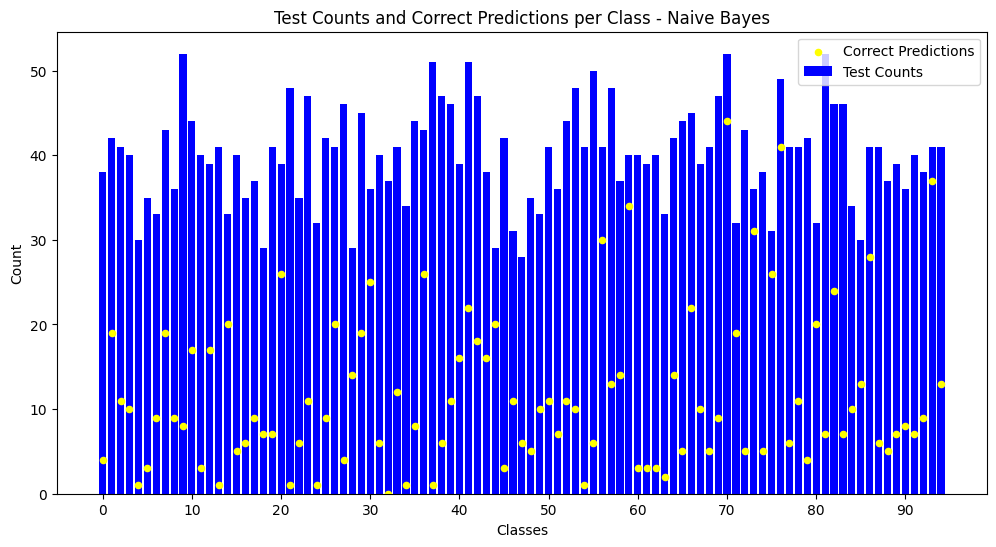

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter

# 각 클래스별 테스트 데이터 개수 계산
test_counts = Counter(y_test)

# 각 클래스별로 예측이 맞은 데이터 개수 계산
correct_predictions = (y_test == y_pred)
correct_counts = Counter(y_test[correct_predictions])

# 클래스 범위
num_classes = 95
classes = np.arange(num_classes)

# 각 클래스별 테스트 데이터 개수를 막대 그래프로 표시
plt.figure(figsize=(12, 6))  # 그래프 크기 조절
plt.bar(classes, [test_counts[i] for i in classes], color='blue', label='Test Counts')

# 예측이 맞은 데이터 개수를 점으로 표시
plt.scatter(classes, [correct_counts[i] if i in correct_counts else 0 for i in classes], color='yellow', label='Correct Predictions', s=20)
plt.xticks(np.arange(0, num_classes, 10))

plt.xlabel('Classes')
plt.ylabel('Count')
plt.title('Test Counts and Correct Predictions per Class - Naive Bayes')
plt.legend()
plt.show()

# **3. Naive Bayes - More Detailed Classification Results** ❌ 정확도가 낮아서 실제 분류에 naive bayes 를 사용하지 않기로 결정


#### **(1) True Class, Predicted Class, 예측 성공 여부, 'True Class'에 부여된 확률, 'True Class'의 가능성 순위 출력 및 배열에 저장**
```
< 출력 예시 >
Test Data 3798 - True Class: 75, Predicted Class: 75
★ Correct Prediction
Predicted Class 75: 0.8302718364556182
Predicted Class 53: 0.06039410499776883
Predicted Class 46: 0.023295783359615862
Predicted Class 85: 0.02051072284243161
Predicted Class 90: 0.010052423649038737
▷ Predicted Probability for True Class 75: 0.8302718364556182
▷ Rank of True Class Probability: 1

Test Data 3799 - True Class: 3, Predicted Class: 85
Predicted Class 85: 0.14691150520003712
Predicted Class 53: 0.14419431466153457
Predicted Class 3: 0.13827188434768237
Predicted Class 46: 0.08342998500021172
Predicted Class 90: 0.07200217664360238
▷ Predicted Probability for True Class 3: 0.13827188434768237
▷ Rank of True Class Probability: 3
```

In [ ]:
probabilities = model.predict_proba(X_test)
sorted_indexes = np.argsort(probabilities, axis=1)

true_class_prob_array = [] # 모델이 계산한 실제 클래스의 확률
true_class_rank_array = [] # 실제 클래스의 예측된 확률 순위 (크기순)
for i, (sorted_index, true_class, pred_class) in enumerate(zip(sorted_indexes, y_test, y_pred)):
    print(f"Test Data {i + 1} - True Class: {true_class}, Predicted Class: {pred_class}")
    if true_class == pred_class:
      print("★ Correct Prediction") # 올바르게 분류한 경우만 출력
    for index in sorted_index[::-1][:5]: # 확률 상위 5개 class만 출력
        print(f"Predicted Class {index}: {probabilities[i][index]}")
    true_class_prob = probabilities[i][true_class]  # 실제 클래스에 대한 예측된 확률
    true_class_prob_array.append(true_class_prob)  # 배열에 추가
    true_class_rank = np.where(sorted_index[::-1] == true_class)[0][0] + 1  # 실제 클래스의 순위
    true_class_rank_array.append(true_class_rank)  # 배열에 추가
    print(f"▷ Predicted Probability for True Class ({true_class}): {true_class_prob}")
    print(f"▷ Rank of True Class Probability: {true_class_rank}")
    print()

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
Predicted Class 82: 0.9990902711167169
Predicted Class 75: 0.00048815609821389487
Predicted Class 68: 5.979216130723117e-05
Predicted Class 18: 4.873903430908155e-05
Predicted Class 21: 3.371753090553769e-05
▷ Predicted Probability for True Class (82): 0.9990902711167169
▷ Rank of True Class Probability: 1

Test Data 3265 - True Class: 29, Predicted Class: 43
Predicted Class 43: 0.2336546393480096
Predicted Class 29: 0.20038051499284498
Predicted Class 67: 0.06574708949943532
Predicted Class 90: 0.04547803526040933
Predicted Class 83: 0.04542823161520712
▷ Predicted Probability for True Class (29): 0.20038051499284498
▷ Rank of True Class Probability: 2

Test Data 3266 - True Class: 51, Predicted Class: 3
Predicted Class 3: 0.14535039959031967
Predicted Class 14: 0.10730233180427845
Predicted Class 63: 0.09855125264120476
Predicted Class 21: 0.07139554684451441
Predicted Class 51: 0.06456347194925192
▷ Predicted Probability for True Class (51): 0.064

##### **방법 1,2,3에 대한 분석** : *best threshold*를 찾고, accuracy, precision, recall, f1-score, confusion matirx 출력
```
<출력 예시>
Best Threshold (largest probability criterion): 0.33564265720488046
Best F1-score: 0.6037483266398929
Confusion Matrix:
[[2757  214]
 [ 378  451]]
Accuracy: 0.8442
Precision: 0.6782
Recall: 0.5440
```

In [ ]:
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score

# 가능한 임계값 생성
p_thresholds = np.unique(proba_top)  # proba_top에서 중복되지 않는 값들을 임계값으로 설정

best_p_f1 = -1
best_p_threshold = None

# 모든 임계값에 대해 F1-score 계산
for p_threshold in p_thresholds:
    predicted_label = (proba_top >= p_threshold).astype(int) # 임계값 이상이면 true
    f1 = f1_score(tf_label, predicted_label)

    # F1-score가 더 높은 경우 업데이트
    if f1 > best_p_f1:
        best_p_f1 = f1
        best_p_threshold = p_threshold

print("Best Threshold (largest probability criterion):", best_p_threshold)
print("Best F1-score:", best_p_f1)

# best_threshold를 기준으로 예측된 레이블 구하기
predicted_labels = (proba_top >= best_p_threshold).astype(int)

conf_matrix = confusion_matrix(tf_label, predicted_labels)

print("Confusion Matrix:")
print(conf_matrix)

# 예측된 레이블과 실제 레이블을 사용하여 accuracy, precision, recall 계산
accuracy = accuracy_score(tf_label, predicted_labels)
precision = precision_score(tf_label, predicted_labels)
recall = recall_score(tf_label, predicted_labels)

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")

Best Threshold (largest probability criterion): 0.33564265720488046
Best F1-score: 0.6037483266398929
Confusion Matrix:
[[2757  214]
 [ 378  451]]
Accuracy: 0.8442
Precision: 0.6782
Recall: 0.5440


In [ ]:
# 후보 2

# 가능한 임계값 생성
g_thresholds = np.unique(proba_gap)  # proba_gap에서 중복되지 않는 값들을 임계값으로 설정

best_g_f1 = -1
best_g_threshold = None

# 모든 임계값에 대해 F1-score 계산
for g_threshold in g_thresholds:
    predicted_label = (proba_gap >= g_threshold).astype(int) # 임계값 이상이면 true
    f1 = f1_score(tf_label, predicted_label)

    # F1-score가 더 높은 경우 업데이트
    if f1 > best_g_f1:
        best_g_f1 = f1
        best_g_threshold = g_threshold

print("Best Threshold (gap criterion):", best_g_threshold)
print("Best F1-score:", best_g_f1)
from sklearn.metrics import confusion_matrix

# best_threshold를 기준으로 예측된 레이블 구하기
predicted_labels = (proba_gap >= best_g_threshold).astype(int)

conf_matrix = confusion_matrix(tf_label, predicted_labels)

print("Confusion Matrix:")
print(conf_matrix)

# 예측된 레이블과 실제 레이블을 사용하여 accuracy, precision, recall 계산
accuracy = accuracy_score(tf_label, predicted_labels)
precision = precision_score(tf_label, predicted_labels)
recall = recall_score(tf_label, predicted_labels)

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")

Best Threshold (gap criterion): 0.22241558645547072
Best F1-score: 0.6087551299589603
Confusion Matrix:
[[2783  188]
 [ 384  445]]
Accuracy: 0.8495
Precision: 0.7030
Recall: 0.5368


In [ ]:
# 방법 3
# 가능한 임계값 생성
r_thresholds = np.unique(proba_ratio)  # proba_ratio에서 중복되지 않는 값들을 임계값으로 설정

best_r_f1 = -1
best_r_threshold = None

# 모든 임계값에 대해 F1-score 계산
for r_threshold in r_thresholds:
    predicted_label = (proba_ratio >= r_threshold).astype(int) # 임계값 이상이면 true
    f1 = f1_score(tf_label, predicted_label)

    # F1-score가 더 높은 경우 업데이트
    if f1 > best_r_f1:
        best_r_f1 = f1
        best_r_threshold = r_threshold

print("Best Threshold (ratio criterion):", best_r_threshold)
print("Best F1-score:", best_r_f1)

# best_threshold를 기준으로 예측된 레이블 구하기
predicted_labels = (proba_ratio >= best_r_threshold).astype(int)

conf_matrix = confusion_matrix(tf_label, predicted_labels)

print("Confusion Matrix:")
print(conf_matrix)

# 예측된 레이블과 실제 레이블을 사용하여 accuracy, precision, recall 계산
accuracy = accuracy_score(tf_label, predicted_labels)
precision = precision_score(tf_label, predicted_labels)
recall = recall_score(tf_label, predicted_labels)

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")

Best Threshold (ratio criterion): 2.7020662776239615
Best F1-score: 0.5745322872661436
Confusion Matrix:
[[2619  352]
 [ 353  476]]
Accuracy: 0.8145
Precision: 0.5749
Recall: 0.5742


#### **(2) (3)을 위한 작업...**
#### *가능성 1위 라벨의 확률, 가능성 2위 라벨의 확률을 correct/wrong case로 나눠 배열에 저장, 평균을 출력, plot을 그려 분포를 확인*
```
<출력 예시>
1st Largest Probability avgerage (Correct case):  0.440449811842864
2nd Largest Probability avgerage (Correct case):  0.08868157411493512
1st Largest Probability avgerage (Wrong case):  0.16885783553732747
2nd Largest Probability avgerage (Correct case):  0.0952104454694786
```



In [ ]:
first_proba_c =[] # 1위 확률 (예측 성공 케이스)
second_proba_c =[] # 2위 확률 (예측 성공 케이스)
first_proba_w =[] # 1위 확률 (예측 실패 케이스)
second_proba_w =[] # 2위 확률 (예측 실패 케이스)
proba_gap_c = [] # 예측 성공시 (1위 확률 - 2위 확률)을 저장
proba_gap_w = [] # 예측 실패시 (1위 확률 - 2위 확률)을 저장
proba_ratio_c = [] # 예측 성공시 (1위 확률 / 2위 확률)을 저장
proba_ratio_w =[] # 예측 실패시 (1위 확률 / 2위 확률)을 저장


# correct, wrong 관계없이
proba_top = [] # 1위 확률들만 저장
proba_gap = [] # 1위 확률 - 2위 확률 저장
proba_ratio = [] # 1위 확률 / 2위 확률 저장
tf_label = [] # correct / wrong 여부 저장 correct = 1, wrong = 0 저장
# 따라서 위 4개 배열에는 모든 test case (3800개)의 해당값을 저장

#각 테스트 데이터에 대해 확률 배열과 실제 클래스를 함께 출력
for i, (sorted_index, true_class, pred_class) in enumerate(zip(sorted_indexes, y_test, y_pred)):
    # print(f"Test Data {i + 1} - True Class: {true_class}, Predicted Class {pred_class}")
    # for index in sorted_index[::-1][:5]: # 확률 상위 5개 class만 출력
    #   print(f"Predicted Class {index}: {probabilities[i][index]}")
    first_proba = probabilities[i][sorted_index[-1]] # 1위 확률
    second_proba = probabilities[i][sorted_index[-2]] # 2위 확률
    proba_top.append(first_proba) # proba_top 는 1위 확률들을 모아놓은 배열
    proba_gap.append(first_proba - second_proba) # proba_gap 은 1위확률 - 2위확률 값들을 저장
    proba_ratio.append(first_proba / second_proba) # proba_ration 는 1위 확률 / 2위 확률 값들을 저장
    if true_class == pred_class:
        first_proba_c.append(first_proba)  # 1위 확률 저장 (plot출력용)
        second_proba_c.append(second_proba) # 2위 확률 저장
        proba_gap_c.append(first_proba - second_proba)
        proba_ratio_c.append(first_proba/second_proba)
        tf_label.append(1)

    else:
      first_proba_w.append(first_proba)  # 가장 큰 확률 저장
      second_proba_w.append(second_proba)
      proba_gap_w.append(first_proba - second_proba)
      proba_ratio_w.append(first_proba/second_proba)
      tf_label.append(0)
    #print()

print("1st Largest Probability avgerage (Correct case): ", sum(first_proba_c)/len(first_proba_c))
print("2nd Largest Probability avgerage (Correct case): ", sum(second_proba_c)/len(second_proba_c))
print("1st Largest Probability avgerage (Wrong case): ", sum(first_proba_w)/len(first_proba_w))
print("2nd Largest Probability avgerage (Correct case): ", sum(second_proba_w)/len(second_proba_w))

1st Largest Probability avgerage (Correct case):  0.536946551988702
2nd Largest Probability avgerage (Correct case):  0.09249586208181239
1st Largest Probability avgerage (Wrong case):  0.25090802380298916
2nd Largest Probability avgerage (Correct case):  0.12127939457742958


#### **(3)'-1'을 부여할 기준 찾기 (unmonitored data에서 0~94에 속하지 않는 data 구별)**


##### **방법 1**: 1위 라벨에 부여된 확률의 크기 분포 (및 plot을 이용해 시각화)



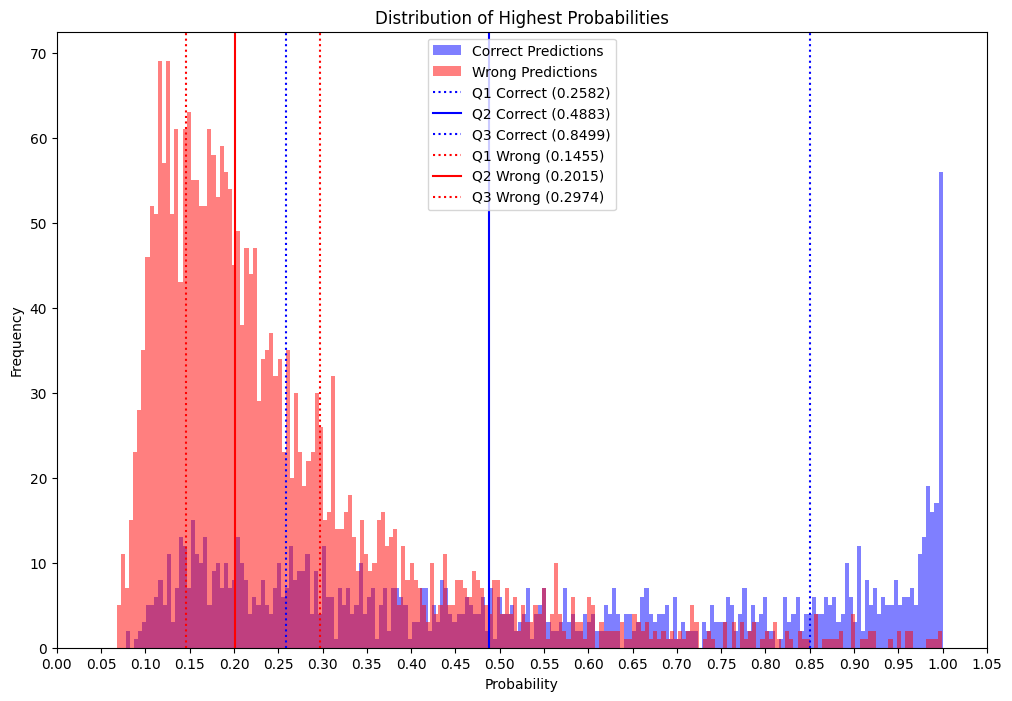

In [ ]:
import matplotlib.pyplot as plt

q1_first_proba_c = np.percentile(first_proba_c, 25)
q2_first_proba_c = np.percentile(first_proba_c, 50)
q3_first_proba_c = np.percentile(first_proba_c, 75)

q1_first_proba_w = np.percentile(first_proba_w, 25)
q2_first_proba_w = np.percentile(first_proba_w, 50)
q3_first_proba_w = np.percentile(first_proba_w, 75)

plt.figure(figsize=(12, 8))

plt.hist(first_proba_c, bins=200, alpha=0.5, color='blue', label='Correct Predictions')
plt.hist(first_proba_w, bins=200, alpha=0.5, color='red', label='Wrong Predictions')

plt.axvline(x=q1_first_proba_c, color='blue', linestyle='dotted', label=f'Q1 Correct ({q1_first_proba_c:.4f})')
plt.axvline(x=q2_first_proba_c, color='blue', linestyle='-', label=f'Q2 Correct ({q2_first_proba_c:.4f})')
plt.axvline(x=q3_first_proba_c, color='blue', linestyle='dotted', label=f'Q3 Correct ({q3_first_proba_c:.4f})')

plt.axvline(x=q1_first_proba_w, color='red', linestyle='dotted', label=f'Q1 Wrong ({q1_first_proba_w:.4f})')
plt.axvline(x=q2_first_proba_w, color='red', linestyle='-', label=f'Q2 Wrong ({q2_first_proba_w:.4f})')
plt.axvline(x=q3_first_proba_w, color='red', linestyle='dotted', label=f'Q3 Wrong ({q3_first_proba_w:.4f})')
plt.xlabel('Probability')
plt.ylabel('Frequency')
plt.title('Distribution of Highest Probabilities')
plt.legend()
plt.xticks(np.arange(0, 1.1, 0.05))  # x축 눈금을 0부터 1까지 0.05 단위로 설정
plt.show()

##### **방법 2**: 1위, 2위 라벨에 부여된 확률 차이의 분포 (및 plot을 이용해 시각화)


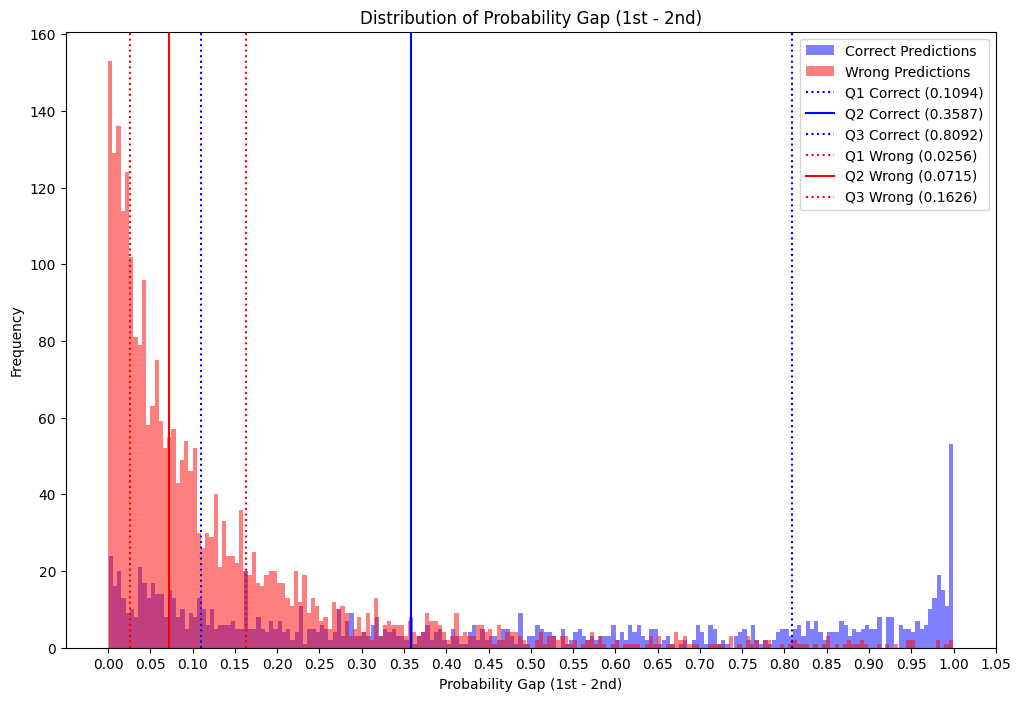

In [ ]:
# proba_gap_c와 proba_gap_w의 상위 25%, 50%, 하위 25% 값을 계산
q1_gap_c = np.percentile(proba_gap_c, 25)
q2_gap_c = np.percentile(proba_gap_c, 50)
q3_gap_c = np.percentile(proba_gap_c, 75)
q1_gap_w = np.percentile(proba_gap_w, 25)
q2_gap_w = np.percentile(proba_gap_w, 50)
q3_gap_w = np.percentile(proba_gap_w, 75)

# proba_ratio_w와 proba_ratio_w의 상위 25%, 하위 25% 값을 계산
q1_ratio_c = np.percentile(proba_ratio_c, 25)
q2_ratio_c = np.percentile(proba_ratio_c, 50)
q3_ratio_c = np.percentile(proba_ratio_c, 75)
q1_ratio_w = np.percentile(proba_ratio_w, 25)
q2_ratio_w = np.percentile(proba_ratio_w, 50)
q3_ratio_w = np.percentile(proba_ratio_w, 75)

plt.figure(figsize=(12, 8))

plt.hist(proba_gap_c, bins=200, alpha=0.5, color='blue', label='Correct Predictions')
plt.hist(proba_gap_w, bins=200, alpha=0.5, color='red', label='Wrong Predictions')

plt.axvline(x=q1_gap_c, color='blue', linestyle='dotted', label=f'Q1 Correct ({q1_gap_c:.4f})')
plt.axvline(x=q2_gap_c, color='blue', linestyle='-', label=f'Q2 Correct ({q2_gap_c:.4f})')
plt.axvline(x=q3_gap_c, color='blue', linestyle='dotted', label=f'Q3 Correct ({q3_gap_c:.4f})')

plt.axvline(x=q1_gap_w, color='red', linestyle='dotted', label=f'Q1 Wrong ({q1_gap_w:.4f})')
plt.axvline(x=q2_gap_w, color='red', linestyle='-', label=f'Q2 Wrong ({q2_gap_w:.4f})')
plt.axvline(x=q3_gap_w, color='red', linestyle='dotted', label=f'Q3 Wrong ({q3_gap_w:.4f})')

plt.xlabel('Probability Gap (1st - 2nd)')
plt.ylabel('Frequency')
plt.title('Distribution of Probability Gap (1st - 2nd)')
plt.legend()
plt.xticks(np.arange(0, 1.1, 0.05))  # x축 눈금을 0부터 1까지 0.05 단위로 설정
plt.show()

##### **방법 3**: 1위, 2위 라벨에 부여된 확률의 비율(1st/2nd) 분포 (및 plot을 이용해 시각화)

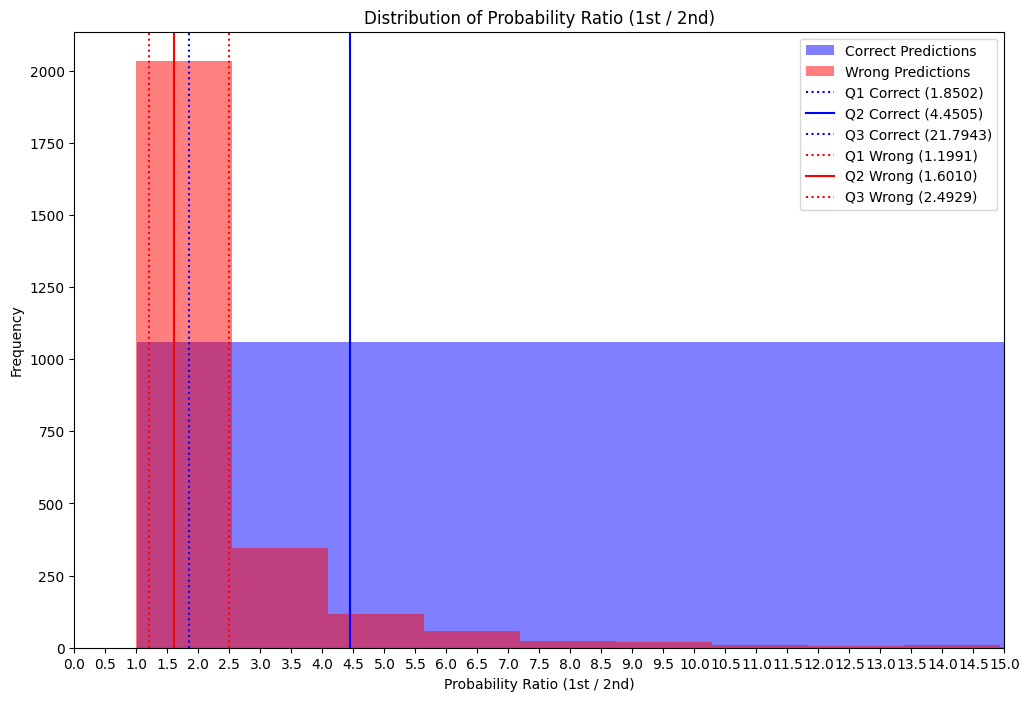

In [ ]:
plt.figure(figsize=(12, 8))

plt.hist(proba_ratio_c, bins=2000, alpha=0.5, color='blue', label='Correct Predictions')
plt.hist(proba_ratio_w, bins=4000, alpha=0.5, color='red', label='Wrong Predictions')

plt.axvline(x=q1_ratio_c, color='blue', linestyle='dotted', label=f'Q1 Correct ({q1_ratio_c:.4f})')
plt.axvline(x=q2_ratio_c, color='blue', linestyle='-', label=f'Q2 Correct ({q2_ratio_c:.4f})')
plt.axvline(x=q3_ratio_c, color='blue', linestyle='dotted', label=f'Q3 Correct ({q3_ratio_c:.4f})')

plt.axvline(x=q1_ratio_w, color='red', linestyle='dotted', label=f'Q1 Wrong ({q1_ratio_w:.4f})')
plt.axvline(x=q2_ratio_w, color='red', linestyle='-', label=f'Q2 Wrong ({q2_ratio_w:.4f})')
plt.axvline(x=q3_ratio_w, color='red', linestyle='dotted', label=f'Q3 Wrong ({q3_ratio_w:.4f})')

plt.xlabel('Probability Ratio (1st / 2nd)')
plt.ylabel('Frequency')
plt.title('Distribution of Probability Ratio (1st / 2nd)')
plt.legend()
plt.xlim(0, 15) # x축 값 15 이상은 제외함 ()
plt.xticks(np.arange(0, 15.1, 0.5))  # x축 눈금을 0부터 15까지 0.5 단위로 설정
plt.show()

##### **방법 1,2,3에 대한 분석** : *best threshold*를 찾고, accuracy, precision, recall, f1-score, confusion matirx 출력 :
```
<출력 예시>
Best Threshold (gap criterion): 0.22241558645547072
Best F1-score: 0.6087551299589603
Confusion Matrix:
[[2783  188]
 [ 384  445]]
Accuracy: 0.8495
Precision: 0.7030
Recall: 0.5368
```

In [ ]:
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score

# 가능한 임계값 생성
p_thresholds = np.unique(proba_top)  # proba_top에서 중복되지 않는 값들을 임계값으로 설정

best_p_f1 = -1
best_p_threshold = None

# 모든 임계값에 대해 F1-score 계산
for p_threshold in p_thresholds:
    predicted_label = (proba_top >= p_threshold).astype(int) # 임계값 이상이면 true
    f1 = f1_score(tf_label, predicted_label)

    # F1-score가 더 높은 경우 업데이트
    if f1 > best_p_f1:
        best_p_f1 = f1
        best_p_threshold = p_threshold

print("Best Threshold (largest probability criterion):", best_p_threshold)
print("Best F1-score:", best_p_f1)

# best_threshold를 기준으로 예측된 레이블 구하기
predicted_labels = (proba_top >= best_p_threshold).astype(int)

conf_matrix = confusion_matrix(tf_label, predicted_labels)

print("Confusion Matrix:")
print(conf_matrix)

# 예측된 레이블과 실제 레이블을 사용하여 accuracy, precision, recall 계산
accuracy = accuracy_score(tf_label, predicted_labels)
precision = precision_score(tf_label, predicted_labels)
recall = recall_score(tf_label, predicted_labels)

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")

Best Threshold (largest probability criterion): 0.3795191723570024
Best F1-score: 0.6128007262823423
Confusion Matrix:
[[2272  403]
 [ 450  675]]
Accuracy: 0.7755
Precision: 0.6262
Recall: 0.6000


In [ ]:
# 후보 2

# 가능한 임계값 생성
g_thresholds = np.unique(proba_gap)  # proba_gap에서 중복되지 않는 값들을 임계값으로 설정

best_g_f1 = -1
best_g_threshold = None

# 모든 임계값에 대해 F1-score 계산
for g_threshold in g_thresholds:
    predicted_label = (proba_gap >= g_threshold).astype(int) # 임계값 이상이면 true
    f1 = f1_score(tf_label, predicted_label)

    # F1-score가 더 높은 경우 업데이트
    if f1 > best_g_f1:
        best_g_f1 = f1
        best_g_threshold = g_threshold

print("Best Threshold (gap criterion):", best_g_threshold)
print("Best F1-score:", best_g_f1)
from sklearn.metrics import confusion_matrix

# best_threshold를 기준으로 예측된 레이블 구하기
predicted_labels = (proba_gap >= best_g_threshold).astype(int)

conf_matrix = confusion_matrix(tf_label, predicted_labels)

print("Confusion Matrix:")
print(conf_matrix)

# 예측된 레이블과 실제 레이블을 사용하여 accuracy, precision, recall 계산
accuracy = accuracy_score(tf_label, predicted_labels)
precision = precision_score(tf_label, predicted_labels)
recall = recall_score(tf_label, predicted_labels)

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")

Best Threshold (gap criterion): 0.2425395796456419
Best F1-score: 0.6141947224749772
Confusion Matrix:
[[2277  398]
 [ 450  675]]
Accuracy: 0.7768
Precision: 0.6291
Recall: 0.6000


In [ ]:
# 방법 3
# 가능한 임계값 생성
r_thresholds = np.unique(proba_ratio)  # proba_ratio에서 중복되지 않는 값들을 임계값으로 설정

best_r_f1 = -1
best_r_threshold = None

# 모든 임계값에 대해 F1-score 계산
for r_threshold in r_thresholds:
    predicted_label = (proba_ratio >= r_threshold).astype(int) # 임계값 이상이면 true
    f1 = f1_score(tf_label, predicted_label)

    # F1-score가 더 높은 경우 업데이트
    if f1 > best_r_f1:
        best_r_f1 = f1
        best_r_threshold = r_threshold

print("Best Threshold (ratio criterion):", best_r_threshold)
print("Best F1-score:", best_r_f1)

# best_threshold를 기준으로 예측된 레이블 구하기
predicted_labels = (proba_ratio >= best_r_threshold).astype(int)

conf_matrix = confusion_matrix(tf_label, predicted_labels)

print("Confusion Matrix:")
print(conf_matrix)

# 예측된 레이블과 실제 레이블을 사용하여 accuracy, precision, recall 계산
accuracy = accuracy_score(tf_label, predicted_labels)
precision = precision_score(tf_label, predicted_labels)
recall = recall_score(tf_label, predicted_labels)

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")

Best Threshold (ratio criterion): 3.2462636581097253
Best F1-score: 0.5963800904977375
Confusion Matrix:
[[2249  426]
 [ 466  659]]
Accuracy: 0.7653
Precision: 0.6074
Recall: 0.5858


# **4. Classification of Unmonitored Data**
# naive bayes 정확도가 낮아서 실제 하지 않아도 될것같음
 ❌
*TO-DO
1. Binary Classification : mark the data as monitored(Y) or NOT(N) - **need to establish criteria for labeling monitored or not**
2. Multi-Class Classification: Re classify samples that were labeled as 'Y' - mark label 0 to 94

## 1. Load Data

In [ ]:
import pickle
from google.colab import drive
drive.mount('/content/gdrive')

TOTAL_URLS = 10000  # total number in the dataset

# Load 10,000 unmon pickle file
print("Loading datafile...")
with open('/content/gdrive/My Drive/Colab Notebooks/unmon_standard10.pkl', 'rb') as f:  # Path to unmon_standard10.pkl in Colab
    x = pickle.load(f)

size = len(x)
print(f'Total samples: {size}')

X1 = [] # Array to store instances (timestamps) - 10,000 instances, e.g., [[0.0, 0.5, 3.4, ...], [0.0, 4.5, ...], [0.0, 1.5, ...], ... [... ,45.8]]
X2 = [] # Array to store instances (direction*size) - size information

for i in range(TOTAL_URLS):
    size_seq = []
    time_seq = []
    for c in x[i]:
        dr = 1 if c > 0 else -1
        time_seq.append(abs(c))
        size_seq.append(dr * 512) # In the pickle file, there is no size information, so the conversion code is set to multiply by 512 uniformly.
    X1.append(time_seq)
    X2.append(size_seq)

print(len(X1)) # Print the length of X1

## 2. Make Dataframe

In [ ]:
n_pack = [] #Array to store total number of packets
n_in = [] #Array to store number of incoming packets : server -> client (size < 0)
n_out = [] #Array to store number of outgoing packets : client -> server (size > 0)
r_in = [] #Array to store ratio of incoming packets
r_out = [] #Array to store ratio of outcoming packets
in_first = [] #Array to store number of incoming packet in First 30 Packets
out_first = [] #Array to store number of outcoming packet in First 30 Packets

for i in range (0,len(X2)):
  count = 0
  count_30 = 0
  for j in range (0,len(X2[i])):
    if X2[i][j] < 0:
      count+=1
      if j < 30: #incoming packet이고 처음 30개 안에 해당된다면
        count_30+=1
  n_pack.append(len(X2[i]))
  n_in.append(count)
  n_out.append(len(X2[i])-count)
  r_in.append(count/len(X2[i]))
  r_out.append(1-count/len(X2[i]))
  in_first.append(count_30)
  out_first.append(30-count_30)

In [ ]:
df_unmon = pd.DataFrame({"total packets": n_pack, "#of incoming packets": n_in, "#of outgoing packets": n_out,
                       "ratio of incoming packets": r_in, "ratio of outgoing packets": r_out,
                       "#of incoming(first30)": in_first, "#of outgoing(first30)": out_first})

df_unmon['label'] = None